In [2]:
#do necessary imports
%load_ext autoreload
%autoreload 2
from pathlib import Path
import sys
import torch
import json
import torch.nn as nn
import torch.optim as optim
from rean.utils import make_run_dir, to_serializable
from rean.data.Dataset import make_datasets
from rean.models.CNN import PlainCNN
from rean.models.P4 import P4CNN
from rean.models.RelaxedP4 import RelaxedP4CNN
from rean.train import train_full, evaluate
from rean.plot import LossPlot
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
#some params that should be the same across all experimental runs

group_order = 4
hidden_dim = 20 #from cohen
out_channels = hidden_dim
classes = 10
kernel_size = 3
num_gconvs = 6 #from cohen
num_epochs = 10
batch_size = 64 #leave this
learning_rate = 0.002 #0.002 is final
gamma = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#full loop
models = ['P4CNN', 'RelaxedP4CNN']
noise_types = ['none', 'iso', 'aniso']
stds = [0.1, 0.2, 0.3]

cpu


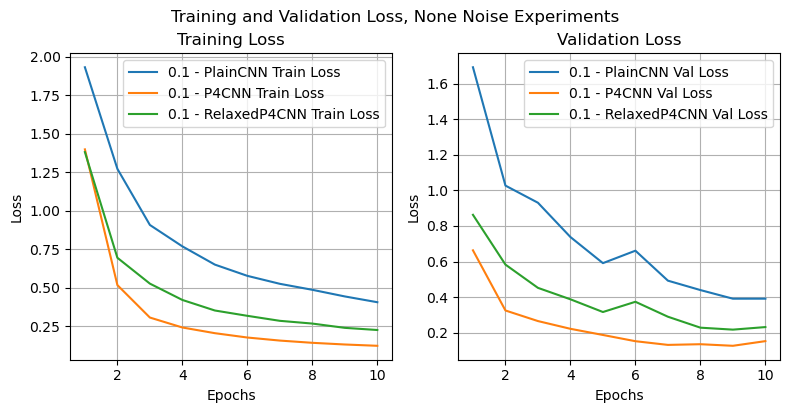

In [34]:
# do the same for each noise type, but plotting both std runs on the same axes
#so, each axes object will have 6 lines: 3 models x 2 stds
models = ['PlainCNN', 'P4CNN', 'RelaxedP4CNN']
noise_type = 'none'
fig, (train_ax, val_ax) = plt.subplots(1,2, figsize = (8, 4))
std = 0
runs = []
tests = []
for model_name in models:
    runpath = Path(f"./runs/{model_name}_{noise_type}_std0_gamma0_lr{learning_rate}")

    #load the rundata in from the json
    rundatapath = runpath / "run_data.json"
    testdatapath = runpath / "test_data.json"
    with rundatapath.open("r", encoding="utf-8") as f:
        run_data = json.load(f)
    with testdatapath.open("r", encoding="utf-8") as f:
        test_data = json.load(f)
    run_data.update(test_data)
    runs.append(run_data)
    tests.append(test_data)

#make loss plots
train_ax = LossPlot(train_ax, runs, labels = ["std", "model_name" ], title = "Training Loss", val = False)
val_ax = LossPlot(val_ax, runs, labels = [ "std", 'model_name'], title = "Validation Loss", train = False)
fig.tight_layout()
fig.suptitle(f"Training and Validation Loss, {noise_type.capitalize()} Noise Experiments", y=1.02)
fig.savefig(f"{noise_type}_loss_plots.png")


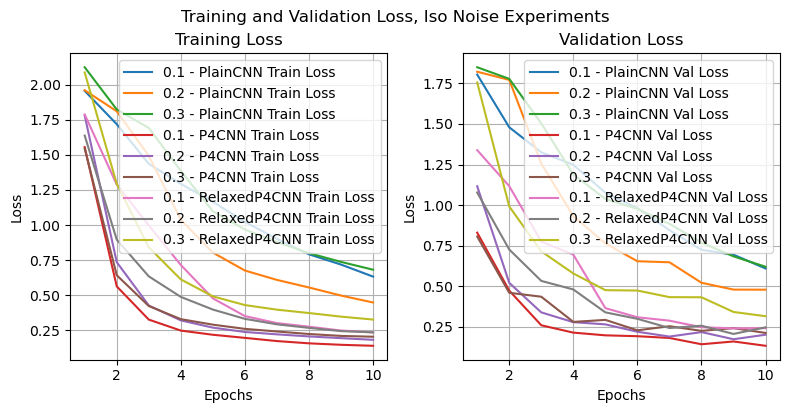

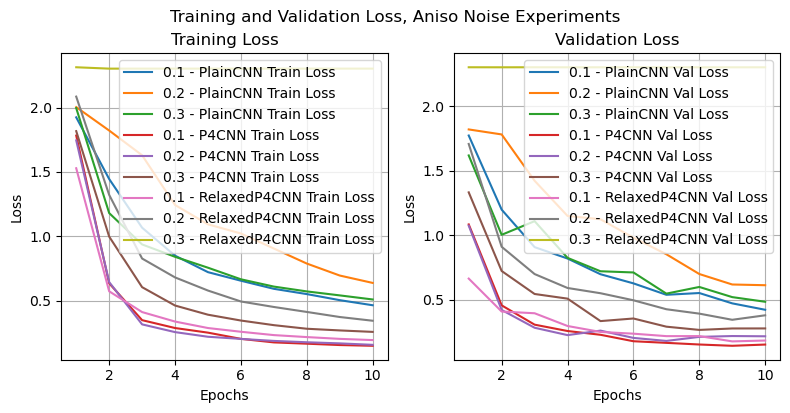

In [35]:
# do the same for each noise type, but plotting both std runs on the same axes
#so, each axes object will have 6 lines: 3 models x 2 stds
noise_types = ['iso', 'aniso']
for noise_type in noise_types:
    fig, (train_ax, val_ax) = plt.subplots(1,2, figsize = (8, 4))
    runs = []
    tests = []
    for model_name in models:
        for std in stds:
            runpath = Path(f"./runs/{model_name}_{noise_type}_std{std}_gamma{gamma}_lr{learning_rate}")

            #load the rundata in from the json
            rundatapath = runpath / "run_data.json"
            testdatapath = runpath / "test_data.json"
            with rundatapath.open("r", encoding="utf-8") as f:
                run_data = json.load(f)
            with testdatapath.open("r", encoding="utf-8") as f:
                test_data = json.load(f)
            run_data.update(test_data)
            runs.append(run_data)
            tests.append(test_data)

    #make loss plots
    train_ax = LossPlot(train_ax, runs, labels = ["std", "model_name" ], title = "Training Loss", val = False)
    val_ax = LossPlot(val_ax, runs, labels = [ "std", 'model_name'], title = "Validation Loss", train = False)
    fig.tight_layout()
    fig.suptitle(f"Training and Validation Loss, {noise_type.capitalize()} Noise Experiments", y=1.02)
    fig.savefig(f"{noise_type}_loss_plots.png")


In [11]:
#fianlly, generate a dataframe for test accuracies across all runs
import pandas as pd
all_runs = []
for model_name in models:
    for noise_type in noise_types + ['none']:
        if noise_type == 'none':
            runpath = Path(f"./runs/{model_name}_none_std0_gamma0_lr{learning_rate}")
            std = 0
            continue
        for std in stds:
            runpath = Path(f"./runs/{model_name}_{noise_type}_std{std}_gamma{gamma}_lr{learning_rate}")
            #load the rundata in from the json
            rundatapath = runpath / "run_data.json"
            testdatapath = runpath / "test_data.json"
            with rundatapath.open("r", encoding="utf-8") as f:
                run_data = json.load(f)
            with testdatapath.open("r", encoding="utf-8") as f:
                test_data = json.load(f)
            run_data.update(test_data)
            all_runs.append(run_data)
df = pd.DataFrame(all_runs)
df = df[['model_name', 'noise_type', 'std', 'test__noisy_acc', 'test_clean_acc']] #get only the stuff we want
display(df)
df.to_csv("test_accuracies.csv", index=False)

,model_name,noise_type,std,test__noisy_acc,test_clean_acc
0,P4CNN,iso,0.1,95.64,39.06
1,P4CNN,iso,0.2,94.49,85.41
2,P4CNN,iso,0.3,93.71,93.36
3,P4CNN,aniso,0.1,95.35,81.85
4,P4CNN,aniso,0.2,93.50,94.11
5,P4CNN,aniso,0.3,91.28,88.17
6,RelaxedP4CNN,iso,0.1,92.69,76.74
7,RelaxedP4CNN,iso,0.2,92.73,80.82
8,RelaxedP4CNN,iso,0.3,90.74,61.70
9,RelaxedP4CNN,aniso,0.1,94.79,95.22


In [33]:
path = 'runs/RelaxedP4CNN_aniso_std0.3_gamma2_lr0.002/model.pt'
model = RelaxedP4CNN(in_channels = 1,
                      hidden_dim = int(hidden_dim),
                      out_channels = int(out_channels),
                      num_gconvs= num_gconvs,
                      classes = classes,
                      kernel_size = kernel_size,
                      group_order = group_order)
model.load_state_dict(torch.load(path, map_location=device))
print(model.gconvs[5].combination_weights)


27544 trainable parameters in RelaxedP4CNN model
Parameter containing:
tensor([[0.3155, 0.3157, 0.3318],
        [0.3153, 0.3157, 0.3321],
        [0.3157, 0.3158, 0.3321],
        [0.3160, 0.3159, 0.3320]], requires_grad=True)


/tmp/ipykernel_751666/74205411.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=device))
